In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import utilities

In [2]:
data = '''In the town of Athy one Jeremy Lanigan
Battered away til he hadnt a pound.
His father died and made him a man again
Left him a farm and ten acres of ground.
He gave a grand party for friends and relations
Who didnt forget him when come to the wall,
And if youll but listen Ill make your eyes glisten
Of the rows and the ructions of Lanigans Ball.
Myself to be sure got free invitation,
For all the nice girls and boys I might ask,
And just in a minute both friends and relations
Were dancing round merry as bees round a cask.
Judy ODaly, that nice little milliner,
She tipped me a wink for to give her a call,
And I soon arrived with Peggy McGilligan
Just in time for Lanigans Ball.
There were lashings of punch and wine for the ladies,
Potatoes and cakes; there was bacon and tea,
There were the Nolans, Dolans, OGradys
Courting the girls and dancing away.
Songs they went round as plenty as water,
The harp that once sounded in Taras old hall,
Sweet Nelly Gray and The Rat Catchers Daughter,
All singing together at Lanigans Ball.
They were doing all kinds of nonsensical polkas
All round the room in a whirligig.
Julia and I, we banished their nonsense
And tipped them the twist of a reel and a jig.
Ach mavrone, how the girls got all mad at me
Danced til youd think the ceiling would fall.
For I spent three weeks at Brooks Academy
Learning new steps for Lanigans Ball.
Three long weeks I spent up in Dublin,
Three long weeks to learn nothing at all,
Three long weeks I spent up in Dublin,
Learning new steps for Lanigans Ball.
She stepped out and I stepped in again,
I stepped out and she stepped in again,
She stepped out and I stepped in again,
Learning new steps for Lanigans Ball.
Boys were all merry and the girls they were hearty
And danced all around in couples and groups,
Til an accident happened, young Terrance McCarthy
Put his right leg through miss Finnertys hoops.
Poor creature fainted and cried Meelia murther,
Called for her brothers and gathered them all.
Carmody swore that hed go no further
Til he had satisfaction at Lanigans Ball.
In the midst of the row miss Kerrigan fainted,
Her cheeks at the same time as red as a rose.
Some of the lads declared she was painted,
She took a small drop too much, I suppose.
Her sweetheart, Ned Morgan, so powerful and able,
When he saw his fair colleen stretched out by the wall,
Tore the left leg from under the table
And smashed all the Chaneys at Lanigans Ball.
Boys, oh boys, twas then there were runctions.
Myself got a lick from big Phelim McHugh.
I soon replied to his introduction
And kicked up a terrible hullabaloo.
Old Casey, the piper, was near being strangled.
They squeezed up his pipes, bellows, chanters and all.
The girls, in their ribbons, they got all entangled
And that put an end to Lanigans Ball.'''

In [3]:
corpus = data.lower().split('\n')
len(corpus)

64

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

vocab_size = len(tokenizer.word_index) + 1
print('total number of words:', vocab_size)

total number of words: 263


In [34]:
seqs = tokenizer.texts_to_sequences(corpus)
subseqs = sum(([sq[:end+1] for end in range(1, len(sq))] for sq in seqs), start=[])

maxlen = max(len(sq) for sq in seqs)
padseqs = pad_sequences(subseqs, padding='pre', maxlen=maxlen, truncating='pre')
print(padseqs.shape)

(453, 11)


In [39]:
trn_sq, trn_lb = padseqs[:, :-1], padseqs[:, -1]
# trn_lb = keras.utils.to_categorical(trn_lb, num_classes=vocab_size)

In [99]:
def fit_song_pred(embed_d=16, hidden_d=16, epochs=10, batch=32):
    model = keras.models.Sequential([
        keras.layers.Embedding(vocab_size, embed_d),
        keras.layers.Bidirectional(keras.layers.LSTM(hidden_d)),
        keras.layers.Dense(vocab_size, activation='softmax')
    ])
    model.summary()
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    history = model.fit(
        trn_sq, trn_lb, batch_size=batch, epochs=epochs, verbose=2
    )
    
    utilities.plot_train_val_metrics(history, ['loss', 'accuracy'])
    
    return model

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 16)          4208      
                                                                 
 bidirectional_9 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 263)               8679      
                                                                 
Total params: 17,111
Trainable params: 17,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
15/15 - 2s - loss: 5.5685 - accuracy: 0.0088 - 2s/epoch - 130ms/step
Epoch 2/500
15/15 - 0s - loss: 5.5541 - accuracy: 0.0464 - 132ms/epoch - 9ms/step
Epoch 3/500
15/15 - 0s - loss: 5.5290 - accuracy: 0.0508 - 132ms/epoch - 9ms/step
Epo

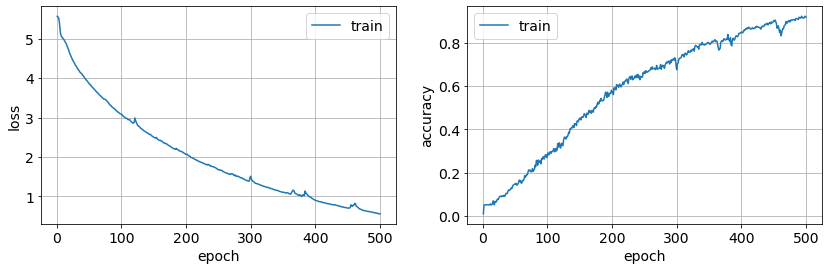

In [108]:
%%time
model = fit_song_pred(epochs=500)

In [109]:
def next_n_words(model, seedtxt, n=1, top=1, tokenizer=tokenizer):
    sqs = tokenizer.texts_to_sequences([seedtxt])
    sqs = pad_sequences(sqs, padding='pre', maxlen=maxlen, truncating='pre')
    words = []
    for i in range(n):
        if top == 1:
            ind = np.argmax(model.predict(sqs, verbose=0), axis=1)
        else:
            probs = model.predict(sqs, verbose=0)
            ind = []
            for prob in probs:
                heap = utilities.Heap(enumerate(prob), get_value=lambda x: x[1])
                k = np.random.choice(top) + 1
                for j in range(k):
                    item = heap.pop()
                ind.append(item[0])    
        words.append(tokenizer.index_word[ind[0]])
        sqs = np.roll(sqs, shift=-1, axis=1)
        sqs[:,-1] = ind
    return words

In [110]:
words = next_n_words(model, 'Laurence went to Dublin', n=100)
print(' '.join(words))

merry and in a nonsense groups might hall lanigan hall glisten glisten stretched me entangled when him fainted when him and fainted him and glisten fainted and glisten fainted him and glisten fainted when him and fainted them when him and fainted him and colleen stretched entangled and colleen them when him and fainted again at again entangled all by and him and glisten lanigan strangled stretched me entangled entangled when him and fainted them when him and fainted him and colleen stretched entangled and colleen them when him and fainted again at again entangled all by and him and


In [111]:
words = next_n_words(model, 'Laurence went to Dublin', n=100, top=3)
print(' '.join(words))

got got a free big ask ask ask hadnt when him when come a again and fainted them friends and brooks her might ask glisten strangled glisten fainted me me eyes glisten glisten eyes wall wall wall colleen him come me rose all me relations entangled squeezed when him when come a to a a academy friends and give her them me entangled all relations relations relations entangled stretched and when come me entangled a glisten died ground relations a kerrigan stretched when and them him a rose glisten fainted a jeremy old hall lanigan glisten made him and glisten


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 64)          16832     
                                                                 
 bidirectional_10 (Bidirecti  (None, 40)               13600     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 263)               10783     
                                                                 
Total params: 41,215
Trainable params: 41,215
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
15/15 - 2s - loss: 5.5695 - accuracy: 0.0265 - 2s/epoch - 114ms/step
Epoch 2/500
15/15 - 0s - loss: 5.5464 - accuracy: 0.0530 - 147ms/epoch - 10ms/step
Epoch 3/500
15/15 - 0s - loss: 5.4925 - accuracy: 0.0574 - 132ms/epoch - 9ms/step
E

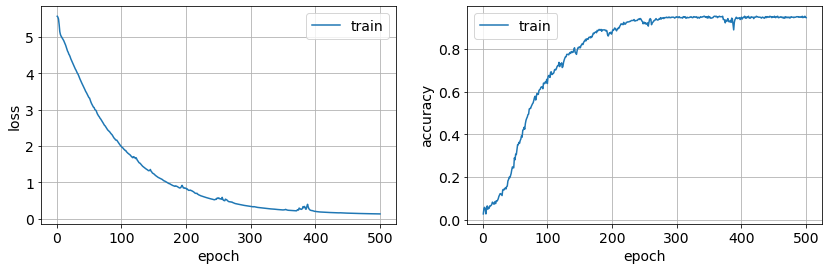

In [112]:
%%time
model2 = fit_song_pred(embed_d=64, hidden_d=20, epochs=500)

In [113]:
words = next_n_words(model2, 'Laurence went to Dublin', n=100)
print(' '.join(words))

round the there room in got a old eyes suppose mavrone eyes entangled new a jig hall didnt come me up up up ground relations a call call didnt call call forget forget forget forget forget come the lanigans ball round lanigans ball lanigans ball lanigans ball ball wall wall as rose lanigans ball lanigans by water dancing miss wall wall wall red as as wall hoops right rose eyes the was being was glisten saw new me a eyes up up up up long all ground up nelly me a eyes up up up up spent mavrone eyes suppose


In [114]:
words = next_n_words(model2, 'Laurence went to Dublin', n=100, top=3)
print(' '.join(words))

just in time a table painted water fainted up ground ground relations brothers then right daughter hall then daughter right hall hall hall eyes relations sweetheart eyes relations up spent replied brothers relations spent eyes relations up spent we eyes nothing sweetheart new relations up brothers three again relations weeks weeks at soon ask daughter mchugh glisten glisten glisten soon forget come the wall mchugh accident ask academy hoops finnertys pipes one hoops happened hadnt sweetheart hall one jeremy polkas ground all invitation able tea of up me ground spent a jig hall call glisten tea was daughter forget forget
